In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.parameter import Parameter
import math
from torch.nn.modules.utils import _pair




from torchvision import datasets
from torchvision import transforms

from utils.model_utils import PatchLoader, NonLocalAggregation
from utils.martemev_utils import compute_psnr, get_freer_gpu, get_closest_diff

from time import time

In [2]:
BATCH_SIZE = 1
NUM_WORKERS = 8

GPU_NUM = 1

K_CLOSEST = 8
HIDDEN_SIZE = 16
PATCH_SIZE = (70, 70)

MODEL_NAME = 'GraphConv.v4.cpugpu'

In [3]:
def get_crops(path):
    data = torch.load(path)
    for tensor in data:
        chunks = torch.split(tensor, PATCH_SIZE[1], dim=1)
        for chunk in chunks[:-1]:
            for i in torch.split(chunk, PATCH_SIZE[0], dim=0)[:-1]:
                yield i

In [4]:
class PatchLoader(torch.utils.data.Dataset):
    def __init__(self, clear_data, noised_data):
        self.clear_data = torch.load(clear_data) 
        self.noised_data = torch.load(noised_data)
 
    def __len__(self):
        return len(self.noised_data)
    def __getitem__(self, index):
        return self.clear_data[index], self.noised_data[index]


In [5]:
train_dataloader = torch.utils.data.DataLoader(
    PatchLoader('../Data/train/clear/normalized_data.tensor',
                '../Data/train/noised/normalized_data.tensor'), 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    PatchLoader('../Data/val/clear/normalized_data.tensor',
                '../Data/val/noised/normalized_data.tensor'), 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)


In [6]:
gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(GPU_NUM))
device

device(type='cuda', index=1)

In [7]:
class LambdaLayer(nn.Module):
    "An easy way to create a pytorch layer for a simple `func`."
    def __init__(self, func):
        "create a layer that simply calls `func` with `x`"
        super().__init__()
        self.func=func

    def forward(self, x):
        return self.func(x)

In [8]:
class CustomGraphCNN(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size,
                 padding=0, k=8, num_fc=1, dilation=1, device=torch.device('cuda:0')):
        super(CustomGraphCNN, self).__init__()
        self.device = device
        
        layers = []
        for _ in range(num_fc):
            layers.append(nn.Linear(n_channels, out_channels))
            layers.append(LambdaLayer(lambda x: x.permute(0, 3, 1, 2)))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.05))
            layers.append(LambdaLayer(lambda x: x.permute(0, 2, 3, 1)))
        
        self.fc = nn.Sequential(*layers)

        self.k = k
        self.kernel_size = _pair(kernel_size)
        self.out_channels = out_channels
        self.dilation = _pair(dilation)
        self.padding = _pair(padding)
        self.stride = _pair(1)
        self.n_channels = n_channels
        
    def forward(self, input_):
        """
        input_ - torch.Tensor, float
        """
        
        hout = ((input_.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0]-1)-1)//self.stride[0])+1
        wout = ((input_.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1]-1)-1)//self.stride[1])+1        
        input_ = F.unfold(input_, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride)        
        b, kernel_channels, hw = input_.shape
        input_ = input_.permute(0, 2, 1).view(b, hw, -1, self.n_channels)
        center_index = (self.kernel_size[0]//2 *  self.kernel_size[1]) - self.kernel_size[0]//2
        diff = input_ - input_[:, :, center_index, :].unsqueeze(2)
#         del input_
        _, indexes = torch.topk(torch.sum(torch.pow(diff, 2), dim=-1),
                                self.k, dim=-1, largest=False, sorted=False) 
        indexes = indexes[..., None].expand(-1, -1, -1, diff.size(-1))
        diff = torch.gather(diff, dim=-2, index=indexes)#.squeeze()
        fc_diff = torch.mean(self.fc(diff), dim=-2)
        return fc_diff.view(fc_diff.shape[0], self.out_channels, hout, wout)


In [9]:
# model = GCNN(K_CLOSEST, 1, HIDDEN_SIZE, patch_size=PATCH_SIZE).cuda(device)
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=(15, 15), stride=5, padding=(15//2, 15//2)),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.05),
    CustomGraphCNN(16, 8, kernel_size=(15, 15), k=K_CLOSEST, padding=(15//2, 15//2)),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.05),
    CustomGraphCNN(8, 16, kernel_size=(15, 15), k=K_CLOSEST, padding=(15//2, 15//2)),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.05),
    nn.ConvTranspose2d(16, 16, kernel_size=(15, 15), stride=5, padding=(15//2, 15//2)),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.05),
    nn.Conv2d(16, 1, kernel_size=(5, 5), padding=(5//2 + 2, 5//2 + 1))
).cuda(device)

optim = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lambda x: 0.97**x)

In [10]:
input = next(iter(train_dataloader))

In [11]:
input[1].shape

torch.Size([1, 960, 4492])

In [12]:
input[1][..., :-1].shape

torch.Size([1, 960, 4491])

In [13]:
%%time

model(input[1].unsqueeze(1).cuda(device)).shape

CPU times: user 57.6 ms, sys: 57.9 ms, total: 116 ms
Wall time: 112 ms


torch.Size([1, 1, 960, 4493])

In [14]:
# Wall time: 1min 15s
# Wall time: 24.1 ms

In [15]:
from tensorboardX import SummaryWriter
import torchvision.utils as vutils


writer = SummaryWriter('./TensorBoard/{}'.format(MODEL_NAME))

In [16]:
val_images_clear =  torch.load('../Data/val/clear/normalized_data.tensor')
val_images_noised =  torch.load('../Data/val/noised/normalized_data.tensor')

In [17]:
for epoch in tqdm.tqdm_notebook(range(100)):
    for train_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(train_dataloader, desc='Train loop', leave=False)):
        model.train()
        ind = epoch * len(train_dataloader) + train_ind
        optim.zero_grad()
        image, noise_image = image.cuda(device).unsqueeze(1), noise_image.cuda(device).unsqueeze(1)
        start_time = time()
        denoised_diff = model(noise_image)[..., :-1]
        end_time = time() - start_time
        writer.add_scalar('train/iteration_time', end_time, ind)
        denoise_image = denoised_diff + noise_image
        max_signals = torch.max(image.view(image.shape[0], -1), dim=1)[0]
        weighted_mse = torch.mean(max_signals * torch.mean(((image - denoise_image)**2).view(image.shape[0], -1), dim=(1)))
        loss = weighted_mse
        writer.add_scalar('train/weighted_mse_loss', loss.item(), ind)
        writer.add_scalar('train/plain_mse_loss', nn.MSELoss()(image, denoise_image).item(), ind)
        loss = loss
        loss.backward()
        optim.step()
        writer.add_scalar('train/psnr', compute_psnr(image, denoise_image), ind)
    scheduler.step()
    model.eval()
    losses, psnrs = [], []
    for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
        image, noise_image = image.cuda(device).unsqueeze(1), noise_image.cuda(device).unsqueeze(1)
        denoised_diff = model(noise_image)[..., :-1]
        denoise_image = denoised_diff + noise_image
        max_signals = torch.max(image.view(image.shape[0], -1), dim=1)[0]
        weighted_mse = torch.mean(max_signals * torch.mean(((image - denoise_image)**2).view(image.shape[0], -1), dim=(1)))
        loss = weighted_mse
        losses.append(loss.item())
        psnrs.append(compute_psnr(image, denoise_image))
    writer.add_scalar('val/psnr', np.mean(psnrs), ind)
    writer.add_scalar('val/combined_loss', np.mean(losses), ind)
    img_indexes = torch.randint(high=len(noise_image), size=(10,))
    dummy_img = torch.cat([image[img_indexes],
                           noise_image[img_indexes],
                           denoise_image[img_indexes]], dim=0).cpu().data
    x = vutils.make_grid(dummy_img, nrow=10)
    writer.add_image('val/crops', x, ind)

#     img_index = torch.randint(high=len(val_images_clear), size=(1,))
#     clear_image = val_images_clear[img_index]
#     noised_image = val_images_noised[img_index]
#     start_time = time()
#     denoised_image = model.forward_image(noised_image.squeeze(0), device).cpu().data.unsqueeze(0)
#     end_time = time() - start_time
#     writer.add_scalar('val/full_image_time', end_time, ind)
#     d_x, d_y = denoised_image.shape[-2:]
#     writer.add_image('val/clear_image', clear_image[:, :d_x, :d_y], ind)
#     writer.add_image('val/noised_image', noised_image[:, :d_x, :d_y], ind)
#     writer.add_image('val/denoised_image', denoised_image[:, :d_x, :d_y], ind)            
            
            

In [24]:
# torch.save(model, 'SavedModels/{}.model'.format(MODEL_NAME))
torch.save(model.state_dict(), 'SavedModels/{}.state_dict'.format(MODEL_NAME))


In [19]:
clears = []
noiseds = []
noises = []

for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
    image, noise_image = image.cuda(device).unsqueeze(1), noise_image.cuda(device).unsqueeze(1)
    denoised_diff = model(noise_image)[..., :960, :4492]
    denoise_image = denoised_diff + noise_image
    clears.append(image.cpu().data)
    noiseds.append(denoise_image.cpu().data)
    noises.append(noise_image.cpu().data)
    if val_ind > 10:
        break

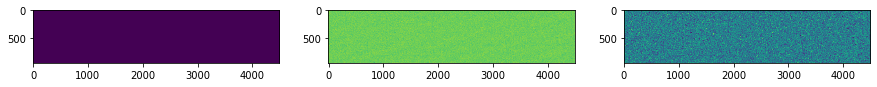

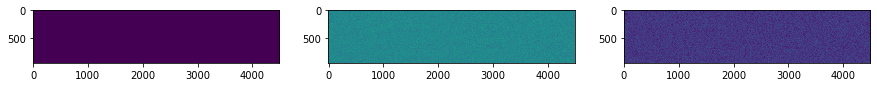

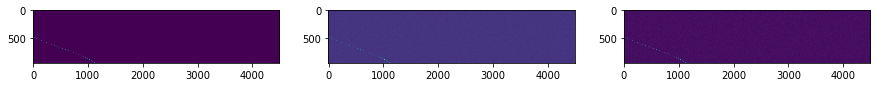

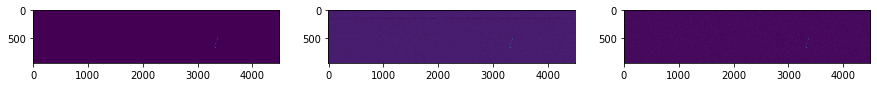

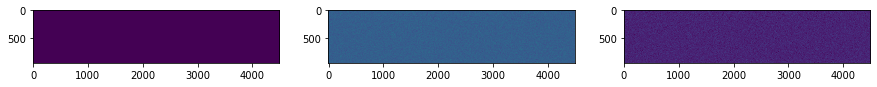

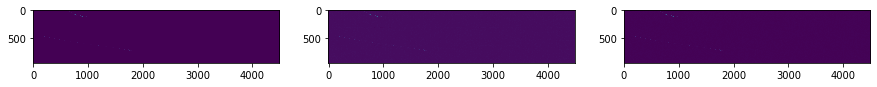

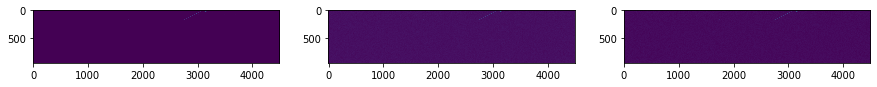

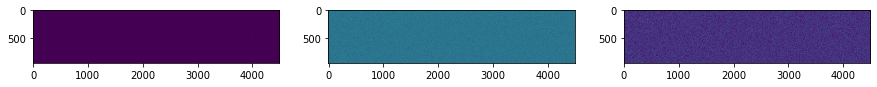

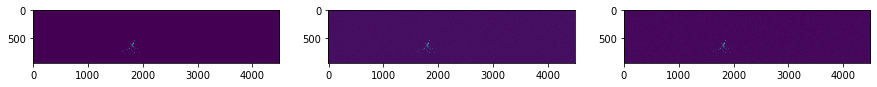

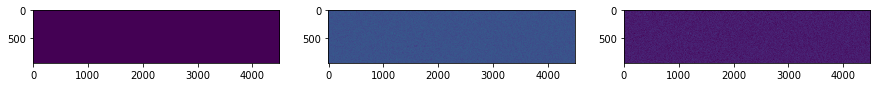

In [20]:
for i in range(10):
    plt.figure(figsize=(15, 15))
    clear = clears[i][0][0]
    noised = noiseds[i][0][0]
    noise = noises[i][0][0]
    plt.subplot(1, 3, 1)
    plt.imshow(clear)
    plt.subplot(1, 3, 2)
    plt.imshow(noised)
    plt.subplot(1, 3, 3)
    plt.imshow(noise)
    plt.show()

In [ ]:
clear.min()

In [ ]:
noised.min()

In [ ]:
noise.min()